### Черненко Сергей Евгеньевич (184-321)

# Классификация с помощью Softmax

Содержание практической работы:

- функция потерь для softmax
- аналитический градиент
- его проверка с помощью численного градиента
- подбор скорости обучения и степени регуляризации на проверочной выборке
- оптимизация функции потерь с помощью стохастического градиентного спуска
- визуализация конечных весов

In [135]:
# Подключим основные библиотеки
from __future__ import print_function

import math
import random
import time
from builtins import object, range

import matplotlib.pyplot as plt
import numpy as np
from past.builtins import xrange

%matplotlib inline

In [136]:
#Загружаем изображения cifar10
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#X_train - обучающая выборка 
#X_ty_trainrain - желаемая обучающая выборка
#X_test - тестовая выборка
#y_test -  желаемая тестовая выборка

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train=[int(i) for i in y_train]
y_train=np.array(y_train)
y_test=[int(i) for i in y_test]
y_test=np.array(y_test)

# Колличество обучающих, валидационных, тестовых и вроверочных изображений
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# подвыбоки
mask = list(range(num_training, num_training + num_validation))
X_val = X_train[mask]
y_val = y_train[mask]
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Первичная обработка данных: преобразования изображений в ряды
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Нормализация данных: вычетаем среднее изображение
mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Добавляем отклонения и преобазуем в колонки
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print('Размерность изображений для обучения: ', X_train.shape)
print('Размерность классов для обучения: ', y_train.shape)
print('Размерность изображений для проверки: ', X_val.shape)
print('Размерность классов для проверки: ', y_val.shape)
print('Размерность изображений для тестирования: ', X_test.shape)
print('Размерность классов для тестирования: ', y_test.shape)
print('Размерность изображений на время разработки: ', X_dev.shape)
print('Размерность классов на время разработки: ', y_dev.shape)

Размерность изображений для обучения:  (49000, 3073)
Размерность классов для обучения:  (49000,)
Размерность изображений для проверки:  (1000, 3073)
Размерность классов для проверки:  (1000,)
Размерность изображений для тестирования:  (1000, 3073)
Размерность классов для тестирования:  (1000,)
Размерность изображений на время разработки:  (500, 3073)
Размерность классов на время разработки:  (500,)


## Softmax классификатор

Сначала напишем алгоритм с использованием циклов.

In [137]:
def softmax_loss_naive(W, X, y, reg):
    """
    Функция потерь Softmax через циклы

    Вводы имеют размерность D, есть C классов, и работает с минисериями из N образцов.

    Ввод:
    - W: Массив numpy размерности (D, C) содержащий веса.
    - X: Массив numpy размерности (N, D) содержащий данные для обучения;
    - y: Массив numpy размерности (N,) содержащий названия классов для обучения.
    - reg: (float) степень регуляризации.

    Возвращает кортеж:
    - потери как float
    - градиент по отношению к весам; массив размерностью как W
    """
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[0]
    num_classes = W.shape[1]
    dims = W.shape[0]
# Задание: рассчитайте потери softmax и градиент не используя циклы.
# Храните потери в loss, а градиент в dW.
# Не забудьте про регуляризацию.

    # ***Начало вашего кода***
    
    for i in range(num_train):
        scores = X[i].dot(W)
        exp = np.exp(scores)
        sum_exp = np.sum(exp)
        scores_normalized = exp / sum_exp
        for j in range(num_classes):
            for dim in range(dims):
                
                dW[dim,j] += X.T[dim,i] * scores_normalized[j]-1 if j == y[i] else X.T[dim,i] * scores_normalized[j]
                
        loss += -np.log(scores_normalized[y[i]])
    loss /= num_train
    loss += reg * np.sum(W*W)
  
    dW /= num_train
    dW += reg * W    
            
        
    # ***Конец вашего кода***

    return loss, dW


In [138]:
# Инициализация матрицы со случайными весами для softmax и используем ее для расчета потерь.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Потери должны быть близки к -log(0.1).
print('Потери: %f' % loss)
print('Проверка работоспособности: %f' % (-np.log(0.1)))

Потери: 2.343983
Проверка работоспособности: 2.302585


In [139]:
#Функция для проверки градиента

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    for i in range(num_checks):
        ix = tuple([random.randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h
        fxph = f(x)
        x[ix] = oldval - h
        fxmh = f(x)
        x[ix] = oldval

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('Численный: %f аналитический: %f, относительная погрешность: %e'
              %(grad_numerical, grad_analytic, rel_error))

In [140]:
# Расчет потерь и градиента
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Как во втором задании используйте численный градиент для отладки кода.
# Численный градиент должен быть близок к аналитическому.
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# И также делаем еще одну проверку с регуляризацией.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

Численный: 0.636558 аналитический: 0.168762, относительная погрешность: 5.808811e-01
Численный: 1.406487 аналитический: 0.201745, относительная погрешность: 7.491097e-01
Численный: -1.581826 аналитический: 0.444381, относительная погрешность: 1.000000e+00
Численный: -0.447381 аналитический: -0.107890, относительная погрешность: 6.113969e-01
Численный: -1.825642 аналитический: 0.979617, относительная погрешность: 1.000000e+00
Численный: -0.271877 аналитический: 0.058704, относительная погрешность: 1.000000e+00
Численный: 1.207812 аналитический: 0.011344, относительная погрешность: 9.813902e-01
Численный: 1.483922 аналитический: 0.669674, относительная погрешность: 3.780877e-01
Численный: -1.083204 аналитический: 0.151126, относительная погрешность: 1.000000e+00
Численный: -0.613496 аналитический: -0.066703, относительная погрешность: 8.038718e-01
Численный: -0.386226 аналитический: 0.358384, относительная погрешность: 1.000000e+00
Численный: 2.170242 аналитический: -0.242390, относитель

In [141]:
def softmax_loss_vectorized(W, X, y, reg):
    
# ввод аналогичен softmax_loss_naive

    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[0]

# Задание: рассчитайте потери softmax и градиент не используя явных циклов.
# Храните потери в loss, а градиент в dW.
# Не забудьте про регуляризацию.

    # ***Начало вашего кода***

    scores = np.dot(X, W)
    exp = np.exp(scores)
    sum_exp = np.sum(exp)
    scores_normalized = exp / sum_exp
    loss_x = scores_normalized[range(num_train), y]
    grad_dW = scores_normalized.copy()
    grad_dW[range(num_train), y] -= 1
       
    loss = np.sum(-np.log(loss_x))
    loss /= num_train
    loss += reg * np.sum(W*W)
      
    dW = np.dot(X.T, grad_dW)
    dW /= num_train
    dW += reg * W
    
    
    # ***Конец вашего кода***

    return loss, dW

In [142]:
# Рассчитаем потери и сравним время.

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери: %e рассчитаны за %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Потери векторизованные: %e рассчитаны за %fs' % (loss_vectorized, toc - tic))

# Используем Норму Фробениуса для сравнения двух градиентов.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Разница потерь: %f' % np.abs(loss_naive - loss_vectorized))
print('Разница градиентов: %f' % grad_difference)

Потери: 2.343983e+00 рассчитаны за 35.043561s
Потери векторизованные: 8.566678e+00 рассчитаны за 0.005006s
Разница потерь: 6.222695
Разница градиентов: 370.841084


### Класс — линейный классификатор

Используйте код из задания по SVM, где вы создавали класс "LinearClassifier".

In [143]:
class LinearClassifier(object):

    def __init__(self):
        
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Обучения линейного классификатора с использованием стохастического градиентного спуска.
        
        Ввод 
        
        - X: Массив numpy размерности (N, D) содержащий данные для обучения;
        - y: Массив numpy размерности (N,) содержащий названия классов для обучения.
        - learning_rate: (float) скорость обучения для оптимизации.
        - reg: (float) степень регуляризации.
        - num_iters: (integer) количество иттераций обучения
        - batch_size: (integer) количество элементов для обучения на каждом шаге оптимизации.
        - verbose: (boolean) если истина, выводить прогресс во время оптимизации.

        Вывод:
        Список содержащий значение потерь в каждой иттерации обучения.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        if self.W is None:
            # Инициализируем W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Используем стохастический градиентный спуск для оптимизации W.
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

        # Задание: взять подвыборку размером batch_size из данных для обучения и их классы
        # для использования в этом шаге градиентного спуска.
        # Храните данные в X_batch, а их соответствующие классы в y_batch.
        # Можете использовать np.random.choice для генерации индексов.

            # ***Начало вашего кода***

            index = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[index]
            y_batch = y[index]

            # ***Конец вашего кода***

            # Оцениваем потери и градиент
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # Обновляем веса

        # Задание: Обновить веса используя градиент и скорость обучения.

            # ***Начало вашего кода***

            self.W += -learning_rate * grad
            
            # ***Конец вашего кода***

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Используя веса после обучения линейного классификатора, предсказать классы для данных X.

        Ввод:
        - X: Массив numpy размерности (N, D) содержащий данные.

        Вывод:
        - y_pred: Предсказанные классы для данных в X.
        y_pred одномерный массив длинной N и каждый элемент это целое число предсказанного класса.
        """
        y_pred = np.zeros(X.shape[0])
        
        # Задание: Реализовать метод предсказания классов, используя полученные при обучении веса.
        # Предсказаные классы записать в y_pred.
        
        # ***Начало вашего кода***

        y_pred = np.argmax(X.dot(self.W),1)
        
        # ***Конец вашего кода***
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        pass


class Softmax(LinearClassifier):

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

Используя проверочную выборку подберите гиперпараметры (степень регуляризации и скорость обучения). Вы должны поэксперементировать с разными диапазонами этих гиперпараметров. Можно добится точности классификации в 0,35 на проверочной выборке.

In [144]:
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# Задание: Напишите код, который подбирает лучшие значения гиперпараметров, корректируя их на проверочной выборке.
# Максимальная точность для проверочной выборки сохраняется в best_val, а полученный классификатор в best_softmax.
# Перекрестная проверка идентична тому, что было во втором задании.

# ***Начало вашего кода***

for learning_rate in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train_pred ==y_train)
        val_accuracy = np.mean(y_val_pred == y_val)
        results[(learning_rate, reg)] = train_accuracy, val_accuracy
        if val_accuracy >= best_val:
            best_lr = learning_rate
            best_val = val_accuracy
            best_softmax = softmax

# ***Конец вашего кода***
    
# Выводим результаты.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('Скорость обучения %e регуляризация %e точность при обучении: %f точность при проверке: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('Максимальная точность на проверочной выборке достигнутая за счет перекрестной проверки: %f' % best_val)

Скорость обучения 1.000000e-07 регуляризация 2.500000e+04 точность при обучении: 0.254122 точность при проверке: 0.272000
Скорость обучения 1.000000e-07 регуляризация 5.000000e+04 точность при обучении: 0.254122 точность при проверке: 0.272000
Скорость обучения 5.000000e-07 регуляризация 2.500000e+04 точность при обучении: 0.254122 точность при проверке: 0.272000
Скорость обучения 5.000000e-07 регуляризация 5.000000e+04 точность при обучении: 0.254122 точность при проверке: 0.272000
Максимальная точность на проверочной выборке достигнутая за счет перекрестной проверки: 0.272000


In [145]:
# Оценим лучшую модель на тестовой выборке.
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Точность на тестовой выборке: %f' % (test_accuracy, ))

Точность на тестовой выборке: 0.268000


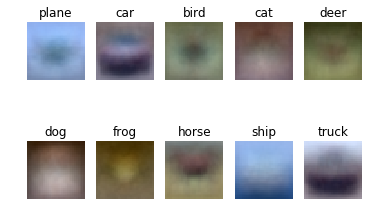

In [146]:
# Визуализируем веса после обучения для каждого класса.
w = best_softmax.W[:-1,:] # уберем отклонения
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])